In [3]:
%matplotlib inline

from __future__ import print_function, division

import os, sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual
from ipywidgets import FloatSlider, IntSlider, Dropdown
from ipywidgets import Checkbox, RadioButtons, fixed 

from IPython.display import display, Math, clear_output

from astropy.convolution import convolve, Gaussian1DKernel

import seaborn as sns
sns.set(context="poster", font_scale=1.5)

# from bokeh import mpl
# from bokeh.plotting import show, output_notebook
# output_notebook()


## import from local files

## Boilerplate path hack to give access to full clustered_SNe package
import os, sys
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))

from clustered_SNe.analysis.constants import m_proton, pc, yr, M_solar, \
                                   gamma, E_0, metallicity_solar
    
from clustered_SNe.analysis.sedov.dimensionalize_sedov import dimensionalized_sedov
from clustered_SNe.analysis.sedov.closed_form_sedov import SedovSolution
from clustered_SNe.analysis.parameter_study_file_structure import make_dirname_from_properties
from clustered_SNe.analysis.parse import RunSummary, Overview, parse_run, cols


general_string_format = ".2e"

from clustered_SNe.analysis.visualize_helpers import plotter, single_run, \
                                                     conduction_comparisons, \
                                                     parameter_study_wrapper, \
                                                     SNe_distplot, \
                                                     plot_zones, \
                                                     plot_shock_location, \
                                                     plot_energy, \
                                                     plot_momentum, \
                                                     plot_luminosity



        
# Holds the most recent run, if more analysis is desired
last_run = RunSummary()    

E_kin:  2.85e+50
E_int:  7.15e+50
checkpoint:  ../src/tmp2/D891EE1B-F4DD-4F54-B827-978752C4D0C3_checkpoint_0095.dat
time:                       9.45e+07 [yr] 	 2.98e+15 [s]
time elapsed:               9.13e+07 [yr] 	 2.88e+15 [s]
background_density:         2.22e-21
Cluster mass:               1.00e+04 M_sol
Number of SNe so far:       103
mass loss prescription:     uniform


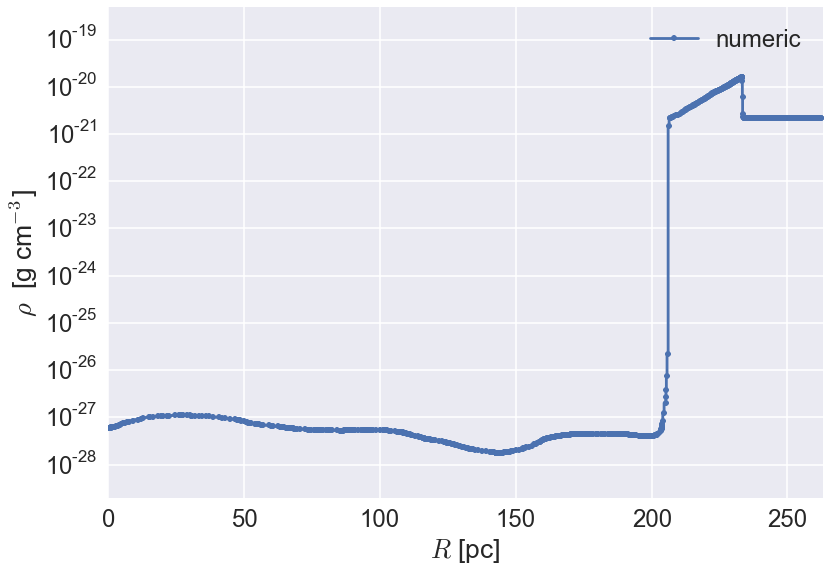

In [4]:
data_dir_default = "../src/"
data_dir_default = "../saved_runs/cluster_parameter_study"


# you don't need the full uuid, just enoughto distinguish it
id_default = ""

# last_run = single_run(data_dir=data_dir_default, id=id_default)
result_widget = interact_manual(single_run,
                                data_dir = widgets.Text(data_dir_default),
                                id = widgets.Text(id_default))
def update_last_run_single_run(widget):
    """Copy the latest result into last_run
    
    Don't reuse this function definition; needs to be bound to the correct result_widget"""
#     raise RuntimeError
    last_run.replace_with(result_widget.widget.result)
result_widget.widget.children[0].on_submit(update_last_run_single_run)
result_widget.widget.children[1].on_submit(update_last_run_single_run)
result_widget.widget.children[2].on_click(update_last_run_single_run)



In [ ]:
data_dir = "../saved_runs/conduction/H_1"
H_0 = "H_0" in data_dir

M_cluster = 10**3* M_solar

conduction_comparisons(M_cluster, H_0, data_dir, num_SNe=2)


In [ ]:
data_dir = "../saved_runs/conduction/H_1"
H_0 = "H_0" in data_dir

M_clusters = np.array([1e2, 1e3, 1e4, 1e5]) * M_solar
for M_cluster in M_clusters:
    plt.close()
    clear_output()
    conduction_comparisons(M_cluster, H_0, data_dir, num_SNe=2)


In [ ]:
result_widget_parameter_study = interact_manual(parameter_study_wrapper,
                                log_Z = FloatSlider(min=-3.0, max=+0.5, step=0.5, value=0),
                                log_n = FloatSlider(min=-3.0, max=+3.0, step=1.0, value=-1),
                                T     = fixed(1e4),
                                with_cooling = True)
def update_last_run_parameter_study(widget):
    """Copy the latest result into last_run
    
    Don't reuse this function definition; needs to be bound to the correct result_widget"""
    last_run.replace_with(result_widget_parameter_study.widget.result)
result_widget_parameter_study.widget.children[-1].on_click(update_last_run_parameter_study)


In [ ]:
plot_zones(last_run)

In [ ]:
sns.distplot(SNe_times)

shape,loc,scale = stats.powerlaw.fit(SNe_times-t_offset, floc=1e7 - t_offset, fscale=SNe_times.max()- t_offset)
print(shape,loc,scale)
plt.plot(SNe_times, 1.9e-6 * (SNe_times-t_offset)**(shape-1), label="fit")
plt.legend(loc="best")

In [ ]:
t = (last_run["times"]) / yr
t_offset = last_run["times"][0] / yr
mask = t > .5

from scipy import stats
SNe_times = last_run["overview"].SNe_times / yr
sns.distplot(SNe_times)
# plt.plot(SNe_times - t_offset, 4e-8 * (SNe_times/1e7)**-.63)
# plt.plot(SNe_times, )

shape,loc,scale = stats.powerlaw.fit(SNe_times-t_offset, floc=1e7 - t_offset, fscale=SNe_times.max()- t_offset)
print(shape,loc,scale)
plt.plot(SNe_times, stats.powerlaw.pdf(SNe_times-t_offset, shape,loc=loc, scale=scale), label="fit")
plt.legend(loc="best")

a_1 = shape-1
a_2 = (a_1 + 3)/5
print("a_1 (dE/dt ~ t^{a_1}) = ", a_1)
print("a_2 (R ~ t^{a_2}) = ", a_2)

plt.figure()

R = last_run["R_shock"] / pc
t = (last_run["times"]) / yr
t_offset = last_run["times"][0] / yr
mask = t > .5
t_0 = 1e7
R_0 = R[np.argmin(np.abs((t-t_offset) - t_0))]

plt.plot(t[mask], R[mask], label="data")
plt.plot(t[mask], R_0 * ((t[mask] - t_offset)/t_0)**.6, linestyle="dashed", label="predicted (a_1 = 0)")
plt.plot(t[mask], R_0 * ((t[mask] - t_offset)/t_0)**a_2, linestyle="dashed", label="predicted (a_1 from SNe)")
plt.plot(t[mask], R_0 * ((t[mask] - t_offset)/t_0)**.53, linestyle="dashed", label="fit by eye")
plt.xlabel("time [yr]")
plt.ylabel("R [pc]")
plt.legend(loc="best")
# plt.xscale("log")
# plt.yscale("log")

plt.figure()
momentum = last_run["momentum"]
t_0 = 1e7
momentum_0 = momentum[np.argmin(np.abs((t-t_offset) - t_0))]

plt.plot(t[mask], momentum[mask], label="data")
plt.plot(t[mask], momentum_0 * ((t[mask] - t_offset)/t_0)**1.4, linestyle="dashed", label="predicted (a_1 = 0)")
plt.plot(t[mask], momentum_0 * ((t[mask] - t_offset)/t_0)**(4*a_2 - 1), linestyle="dashed", label="predicted (a_1 free)")
plt.plot(t[mask], momentum_0 * ((t[mask] - t_offset)/t_0)**((.53*4) - 1), linestyle="dashed", label="predicted by shock fit (a_1=0)")
plt.plot(t[mask], momentum_0 * ((t[mask] - t_offset)/t_0)**1.1, linestyle="dashed", label="fit by eye")
plt.xlabel("time [yr]")
plt.ylabel("momentum [g cm s-1]")
plt.legend(loc="best")
# plt.xscale("log")
# plt.yscale("log")

In [ ]:
plot_shock_location(last_run)

In [ ]:
_ = interact(plot_energy,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))

In [ ]:
# last_run["overview"].cluster_mass = 100 * M_solar

In [ ]:
_ = interact(plot_momentum,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]),
         clear_previous=fixed(True),
         distplot=fixed(True))

In [ ]:
_ = interact(plot_luminosity,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))
